## Declaração de bibliotecas e demais configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import csv
import matplotlib.gridspec as gridspec

import scipy

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture

from sklearn import metrics

import sklearn.preprocessing as preproc
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Funções relacionadas ao método ou auxiliares

In [2]:
#Função de leitura dos dados------------------------------------
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x

## Leitura dos dados
* Os dados considerados aqui foram obtidos da USGS

* Atributos são:
    * latitude
    * longitude
    * depth
    * mag
    * gap
    * dmin
    * rms
    * horizontalError
    * depthError

* Classes:
    * 1 - MB; (azul escuro)
    * 2 - MD; (ciano)
    * 3 - ML; (verde)
    * 4 - MW; (laranja)
    
##### Definição dos atributos em: https://earthquake.usgs.gov/data/comcat/data-eventterms.php
##### Definição das classes em: https://www.usgs.gov/natural-hazards/earthquake-hazards/science/magnitude-types

In [3]:
#Dados
path = 'EartQuakes_USGS_mar-abr2020.csv'

#Leitura dos dados
y,x = read_class_data(path)

#Nomes das classes
nomesClasses = ['MB','MD','ML','MW']

## Visualizacão dos dados

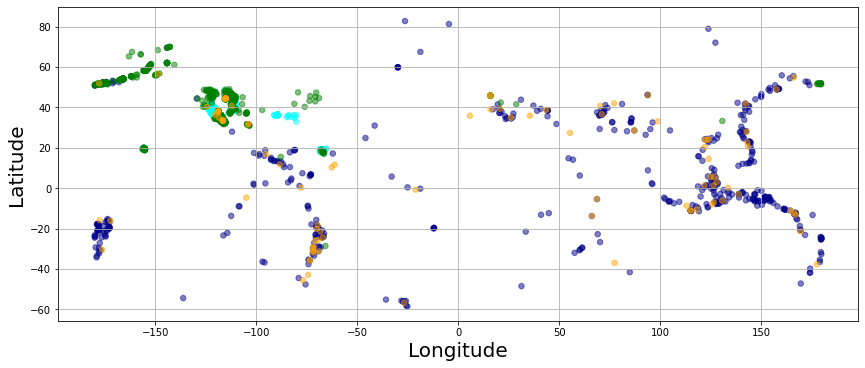

In [4]:
classColor = ['darkblue','cyan','green','orange']
vecCol = []
for i in y: vecCol.append( classColor[int(i-1)] )    

FS = (15,5) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

#ax.scatter( x[:,1], x[:,0], s=x[:,3], c=vecCol, alpha=0.5, label='Localização/Magnitude')
ax.scatter( x[:,1], x[:,0], s=30, c=vecCol, alpha=0.5)
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

#ax.set(xlim=(np.min(x[:,0])-1,np.max(x[:,0])+1), ylim=(np.min(x[:,1])-1,np.max(x[:,1])+1))
ax.set_aspect('equal', 'box')

ax.grid(True)

## Escolha dos atributos e normalização dos dados (pelo máximo)

In [6]:
#0 - latitude, 1 - longitude, 2 - depth, 3 - mag
#4 - gap, 5 - dmin, 6 - rms, 7 - horizontalError, 8 - depthError
#atributos = [0,1,2,3] #Permite escolhar qual atributo usar
atributos = [2,3,4,5,6,7,8] #Permite escolhar qual atributo usar
x_sub = x[:,atributos]

#Normalização...
x_sub = preprocessing.normalize(x_sub, axis=0, norm='max')

## Agrupamento dos dados

In [7]:
n_clusters = 4 #Usar até 8 ou acrescentar mais cores no vetor 'cores' 
epsilon = 0.0001
#----------

#===Instanciação e execução de agrupamento hierárquico
aglom = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
res = aglom.fit(x_sub)
agrupWard = res.labels_

#===Instanciação e execução do algoritmo K-Médias
km = KMeans(n_clusters=n_clusters, max_iter=1000, tol=epsilon)
agrupKM = km.fit_predict(x_sub)

#===Instanciação e modelagem via GMM
gmm = mixture.GaussianMixture(n_components=n_clusters)
gmm.fit(x_sub)
agrup = []
for i in range(x.shape[0]): agrup.append( np.argmax( gmm.predict_proba( [x_sub[i,:]] ) ) )
agrupGMM = np.array(agrup)

## Avaliação do desempenho
* Homogeneidade
* Completude
* Medida $V$

In [8]:
ho_ward,co_ward,vm_ward = metrics.homogeneity_completeness_v_measure(y, agrupWard)

print("---Método de Ward---")
print("Homogeneidade: %f   Completude: %f   Medida-V: %f \n\n"%(ho_ward,co_ward,vm_ward))


ho_km,co_km,vm_km = metrics.homogeneity_completeness_v_measure(y, agrupKM)

print("---K-Médias---")
print("Homogeneidade: %f   Completude: %f   Medida-V: %f \n\n"%(ho_km,co_km,vm_km))


ho_gmm,co_gmm,vm_gmm = metrics.homogeneity_completeness_v_measure(y, agrupGMM)

print("---Agrupamento via GMM---")
print("Homogeneidade: %f   Completude: %f   Medida-V: %f \n\n"%(ho_gmm,co_gmm,vm_gmm))

---Método de Ward---
Homogeneidade: 0.258944   Completude: 0.195811   Medida-V: 0.222995 


---K-Médias---
Homogeneidade: 0.281219   Completude: 0.222285   Medida-V: 0.248303 


---Agrupamento via GMM---
Homogeneidade: 0.275000   Completude: 0.245387   Medida-V: 0.259351 




## Visualização do resultado de agrupamento

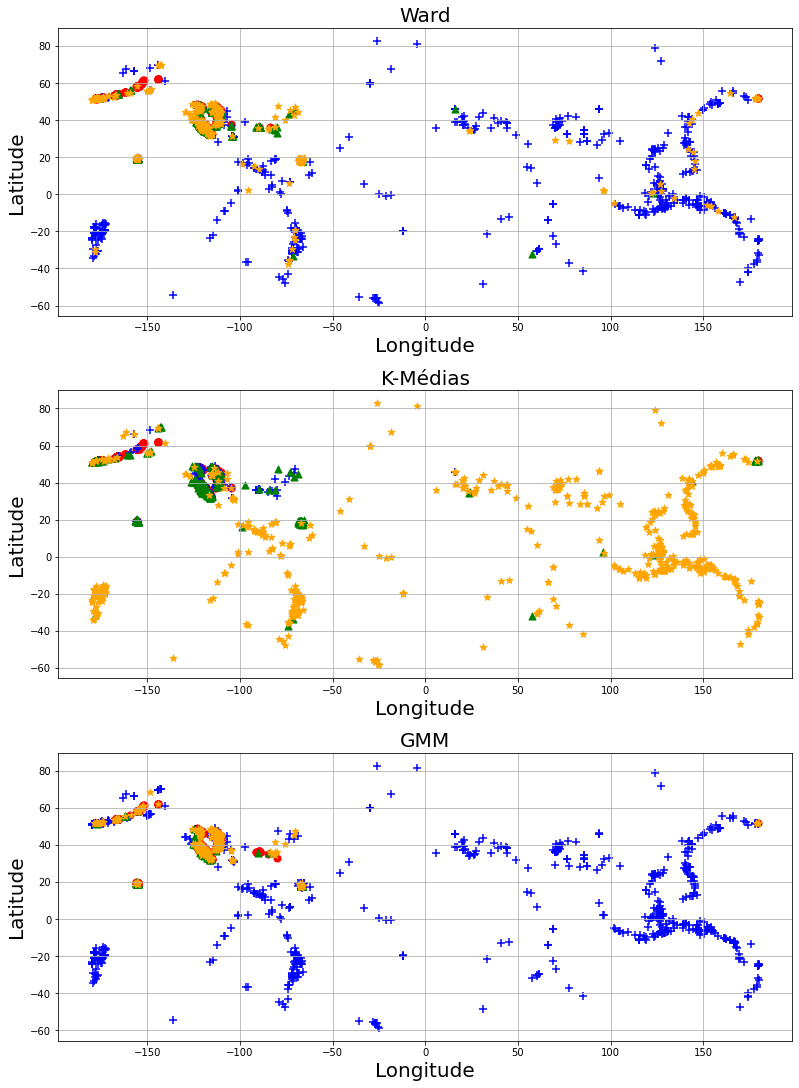

In [9]:
FS = (15,15) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)

cores = ['red','blue','green','orange','magenta','cyan','darkred','grey']
marcadores = ['o','+','^','*','D','x','p','h']

#Ward
ax = fig.add_subplot(spec[0,0])
for i in range(n_clusters):
    pos = np.where( agrupWard == i )
    ax.scatter(x[pos,1], x[pos,0], marker=marcadores[i], c=cores[i], s=50)    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('Ward',fontsize=20)
ax.grid(True) 

#K-Médias
ax = fig.add_subplot(spec[1,0])
for i in range(n_clusters):
    pos = np.where( agrupKM == i )
    ax.scatter(x[pos,1], x[pos,0], marker=marcadores[i], c=cores[i], s=50)    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('K-Médias',fontsize=20)
ax.grid(True) 

#GMM
ax = fig.add_subplot(spec[2,0])
for i in range(n_clusters):
    pos = np.where( agrupGMM == i )
    ax.scatter(x[pos,1], x[pos,0], marker=marcadores[i], c=cores[i], s=50)    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('GMM',fontsize=20)
ax.grid(True) 


#plt.savefig(path_out,dpi=300)
plt.show()

## Mais uma avaliação sobre o número de agrupamentos
* Teste sobre o K-Médias
* Investigação sobre $k \in \{2,\ldots,80\}$

In [10]:
vecK = []
vecV = []; vecH = []; vecC = []
for k in range(2,81):
    #Instancia e agrupa os dados...
    km = KMeans(n_clusters=k, max_iter=1000, tol=epsilon)
    agrupKM = km.fit_predict(x_sub)
    ho_km,co_km,vm_km = metrics.homogeneity_completeness_v_measure(y, agrupKM)
    vecK.append(k) 
    vecV.append(vm_km)
    vecH.append(ho_km)
    vecC.append(co_km)

Text(0, 0.5, '$V$')

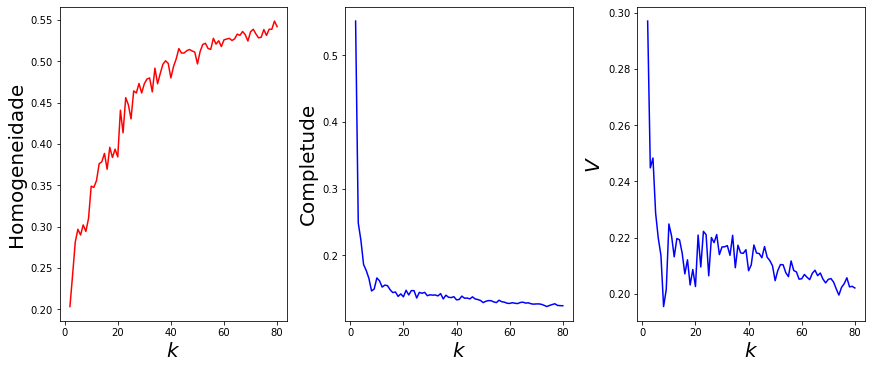

In [11]:
FS = (12,5) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

#Gráfico Ho
ax = fig.add_subplot(spec[0,0])
ax.plot(vecK,vecH,'r-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('Homogeneidade',fontsize=20)

#Gráfico Co
ax = fig.add_subplot(spec[0,1])
ax.plot(vecK,vecC,'b-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('Completude',fontsize=20)

#Gráfico V
ax = fig.add_subplot(spec[0,2])
ax.plot(vecK,vecV,'b-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('$V$',fontsize=20)